In [1]:
import numpy as np 
import pandas as pd
import os


In [30]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from wordcloud import WordCloud,STOPWORDS
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from collections import defaultdict
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk import ngrams
import seaborn as sns
import pandas as pd
import numpy as np
import os
import re

In [3]:
df = pd.read_csv('/content/RealFake Job Posts/fake_job_postings.csv')
df.head(5)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [4]:
df.shape

(17880, 18)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
job_id,17880.0,8940.500000,5161.655742,1.0,4470.75,8940.5,13410.25,17880.0
telecommuting,17880.0,0.042897,0.202631,0.0,0.00,0.0,0.00,1.0
has_company_logo,17880.0,0.795302,0.403492,0.0,1.00,1.0,1.00,1.0
has_questions,17880.0,0.491723,0.499945,0.0,0.00,0.0,1.00,1.0
fraudulent,17880.0,0.048434,0.214688,0.0,0.00,0.0,0.00,1.0


In [7]:
df.duplicated().sum()

0

In [8]:
df.isna().sum().sort_values(ascending=False)

salary_range           15012
department             11547
required_education      8105
benefits                7210
required_experience     7050
function                6455
industry                4903
employment_type         3471
company_profile         3308
requirements            2695
location                 346
description                1
job_id                     0
telecommuting              0
has_questions              0
has_company_logo           0
title                      0
fraudulent                 0
dtype: int64

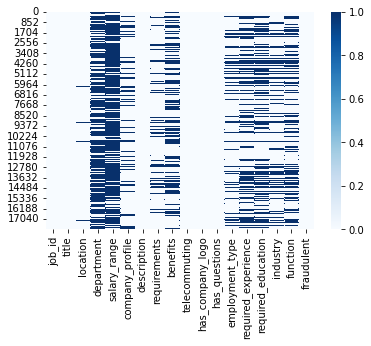

In [9]:
sns.heatmap(df.isnull(),cmap="Blues")

<ipython-input-10-b3b46e716043>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr , mask=np.zeros_like(corr, dtype=np.bool) , cmap=sns.diverging_palette(-100,0,as_cmap=True) , square = True)


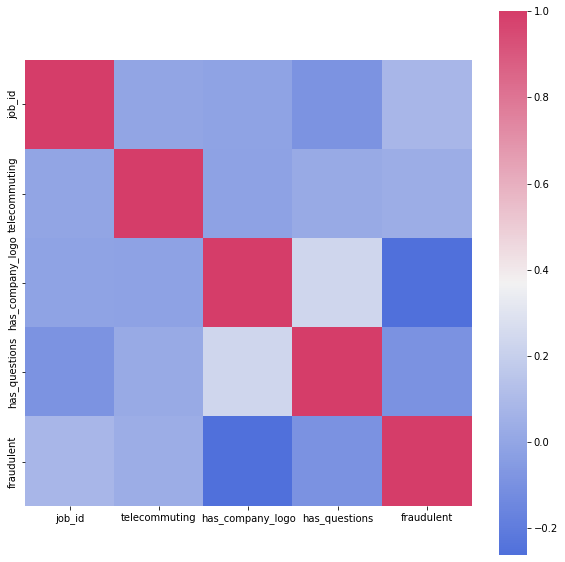

In [10]:
plt.figure(figsize = (10,10))
corr = df.corr()
sns.heatmap(corr , mask=np.zeros_like(corr, dtype=np.bool) , cmap=sns.diverging_palette(-100,0,as_cmap=True) , square = True)

In [12]:
df_1 = df.drop(['job_id' , 'salary_range' , 'telecommuting' , 'has_company_logo' , 'has_questions'] , axis = 1)
df_1['Country'] = df_1['location'].str[:2]
df_1.head(5)

,title,location,department,company_profile,description,requirements,benefits,employment_type,required_experience,required_education,industry,function,fraudulent,Country
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,Other,Internship,NaN,NaN,Marketing,0,US
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,NZ
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,NaN,NaN,NaN,NaN,NaN,0,US
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US
4,Bill Review Manager,"US, FL, Fort Worth",NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US


In [13]:
df_1.shape


(17880, 14)

In [14]:
df_1.fillna(" ", inplace=True)
df_1.isnull().sum()

title                  0
location               0
department             0
company_profile        0
description            0
requirements           0
benefits               0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
Country                0
dtype: int64

In [15]:
df_industry = df_1[df_1['fraudulent']== 1]
df_vc = df_industry.groupby(["industry"]).sum()
df_vc.head(10)

,fraudulent
industry,
,275
Accounting,57
Airlines/Aviation,1
Animation,2
Apparel & Fashion,2
Automotive,5
Banking,3
Biotechnology,4
Broadcast Media,1


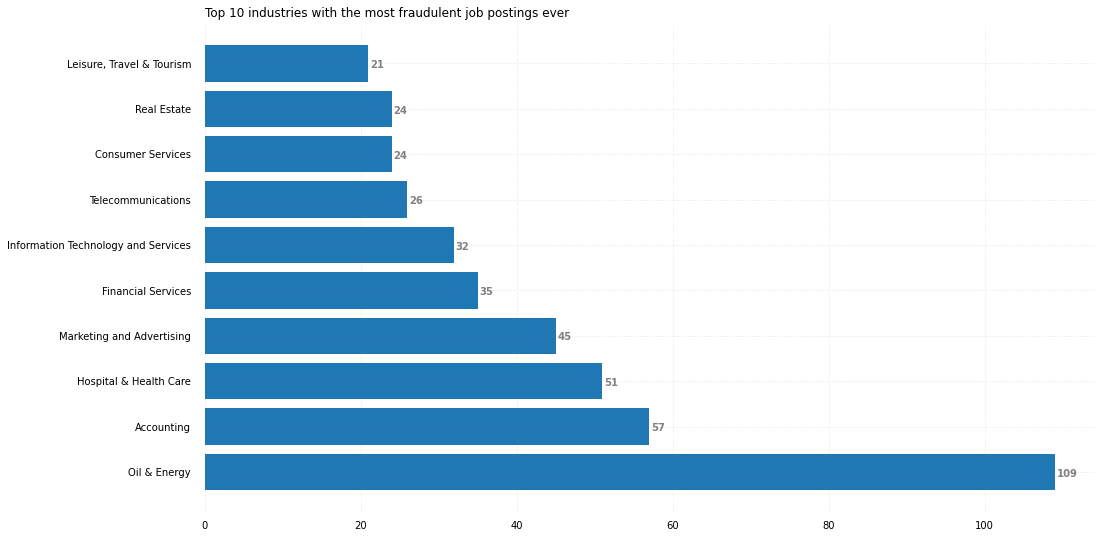

In [17]:
df_vc = df_vc.sort_values(by=['fraudulent'])
dfv = df_vc.tail(11)

x = dfv.index[:-1]
y = dfv["fraudulent"][:-1]

fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(x, y)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

# Add Plot Title
ax.set_title('Top 10 industries with the most fraudulent job postings ever',loc ='left',)

plt.show()

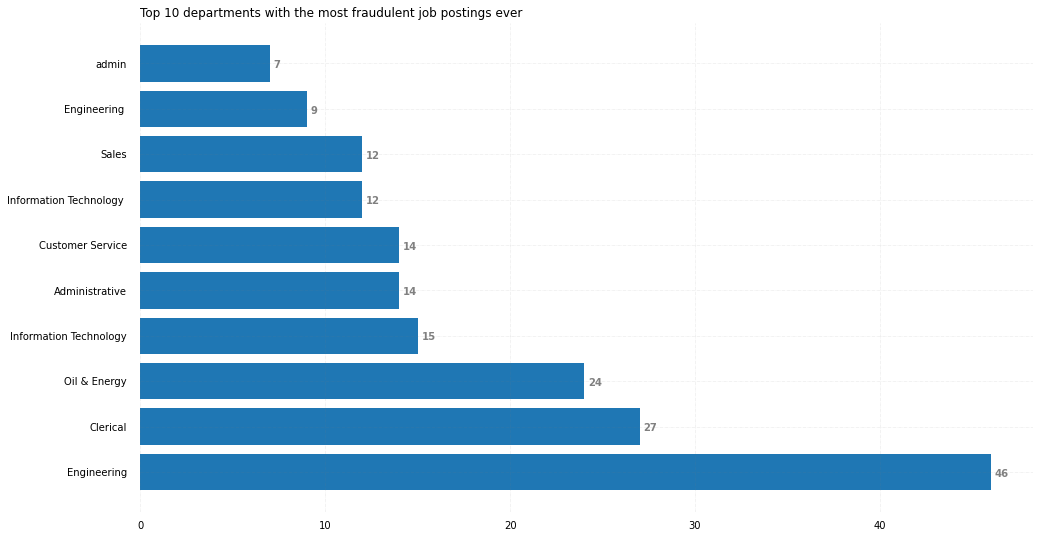

In [19]:
df_vc2 = df_1[df_1['fraudulent']== 1]
df_vc2 = df_vc2.groupby(["department"]).sum()
df_vc2 = df_vc2.sort_values(by=['fraudulent'])
dfv = df_vc2.tail(11)

x = dfv.index[:-1]
y = dfv["fraudulent"][:-1]

fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(x, y)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
ax.invert_yaxis()
 
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

ax.set_title('Top 10 departments with the most fraudulent job postings ever',loc ='left',)

plt.show()

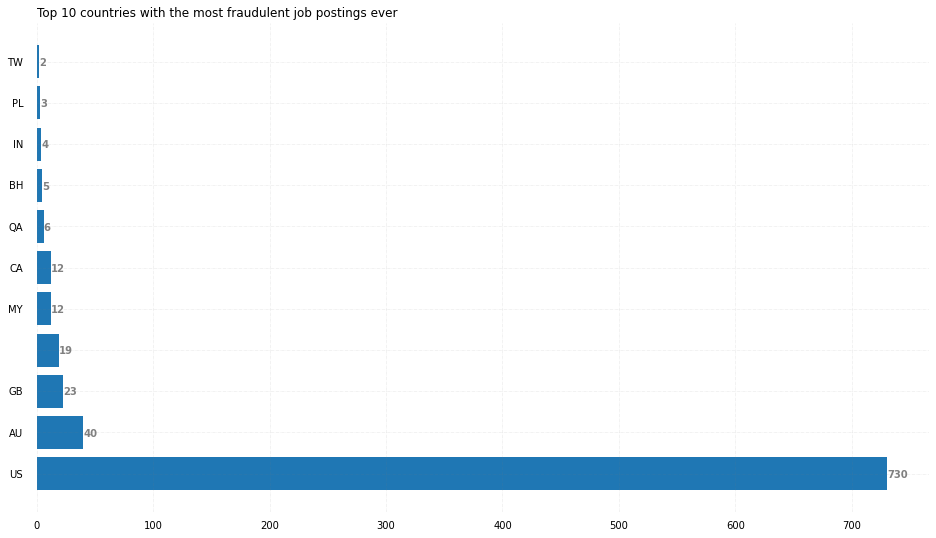

In [21]:
df_vc2 = df_1[df_1['fraudulent']== 1]
df_vc2 = df_vc2.groupby(["Country"]).sum()
df_vc2 = df_vc2.sort_values(by=['fraudulent'])
dfv = df_vc2.tail(11)

x = dfv.index
y = dfv["fraudulent"]

fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(x, y)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)

ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
ax.set_title('Top 10 countries with the most fraudulent job postings ever',loc ='left',)

plt.show()

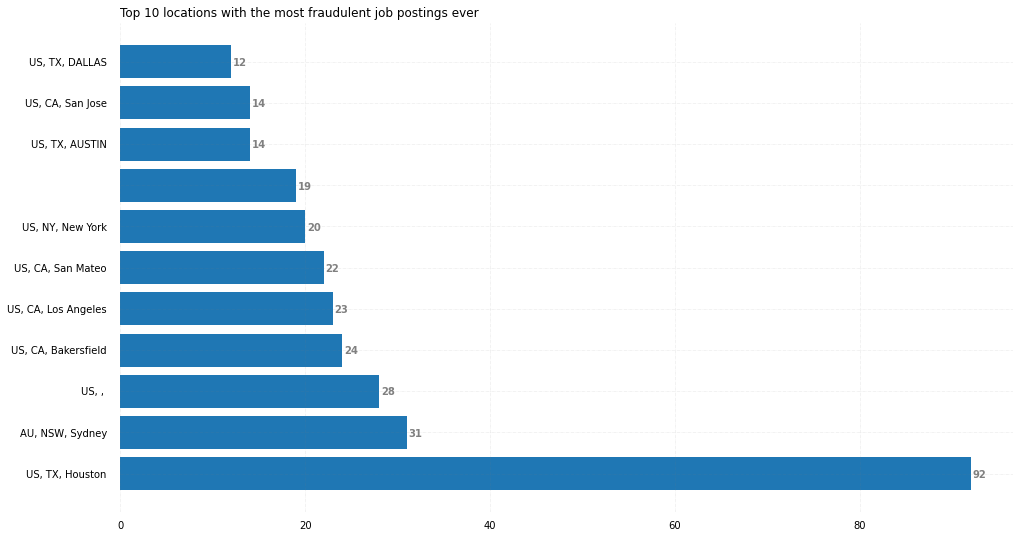

In [23]:
df_vc2 = df_1[df_1['fraudulent']== 1]
df_vc2 = df_vc2.groupby(["location"]).sum()
df_vc2 = df_vc2.sort_values(by=['fraudulent'])
dfv = df_vc2.tail(11)

x = dfv.index
y = dfv["fraudulent"]

fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(x, y)


for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)


ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 

ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
ax.set_title('Top 10 locations with the most fraudulent job postings ever',loc ='left',)

plt.show()

In [24]:
del df['salary_range']
del df['job_id']
df.fillna(" ",inplace = True)

In [25]:
df['text'] = df['title'] + ' ' + df['location'] + ' ' + df['department'] + ' ' + df['company_profile'] + ' ' + df['description'] + ' ' + df['requirements'] + ' ' + df['benefits'] + ' ' + df['employment_type'] + ' ' + df['required_education'] + ' ' + df['industry'] + ' ' + df['function']
df.text[0]

"Marketing Intern US, NY, New York Marketing We're Food52, and we've created a groundbreaking and award-winning cooking site. We support, connect, and celebrate home cooks, and give them everything they need in one place.We have a top editorial, business, and engineering team. We're focused on using technology to find new and better ways to connect people around their specific food interests, and to offer them superb, highly curated information about food and cooking. We attract the most talented home cooks and contributors in the country; we also publish well-known professionals like Mario Batali, Gwyneth Paltrow, and Danny Meyer. And we have partnerships with Whole Foods Market and Random House.Food52 has been named the best food website by the James Beard Foundation and IACP, and has been featured in the New York Times, NPR, Pando Daily, TechCrunch, and on the Today Show.We're located in Chelsea, in New York City. Food52, a fast-growing, James Beard Award-winning online food communi

In [26]:
del df['title']
del df['location']
del df['department']
del df['company_profile']
del df['description']
del df['requirements']
del df['benefits']
del df['employment_type']
del df['required_experience']
del df['required_education']
del df['industry']
del df['function']

In [27]:
df.head(5)

,telecommuting,has_company_logo,has_questions,fraudulent,text
0,0,1,0,0,"Marketing Intern US, NY, New York Marketing We..."
1,0,1,0,0,"Customer Service - Cloud Video Production NZ, ..."
2,0,1,0,0,"Commissioning Machinery Assistant (CMA) US, IA..."
3,0,1,0,0,"Account Executive - Washington DC US, DC, Wash..."
4,0,1,1,0,"Bill Review Manager US, FL, Fort Worth SpotS..."


In [31]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [32]:
stop=set(stopwords.words("english"))

In [34]:
def clean(text):
    text=text.lower()
    obj=re.compile(r"<.*?>")                     
    text=obj.sub(r" ",text)
    obj=re.compile(r"https://\S+|http://\S+")    
    text=obj.sub(r" ",text)
    obj=re.compile(r"[^\w\s]")                   #removing punctuations
    text=obj.sub(r" ",text)
    obj=re.compile(r"\d{1,}")                    #removing digits
    text=obj.sub(r" ",text)
    obj=re.compile(r"_+")                        #removing underscore
    text=obj.sub(r" ",text)
    obj=re.compile(r"\s\w\s")                    #removing single character
    text=obj.sub(r" ",text)
    obj=re.compile(r"\s{2,}")                    #removing multiple spaces
    text=obj.sub(r" ",text)
    
    stemmer = SnowballStemmer("english")
    text=[stemmer.stem(word) for word in text.split() if word not in stop]
    
    return " ".join(text)

In [36]:
df["text"]=df["text"].apply(clean)

In [37]:
def generate(text,ngram):
    n_grams=ngrams(word_tokenize(text),ngram)
    grams=[" ".join(val) for val in n_grams]
    return grams

(-0.5, 799.5, 799.5, -0.5)

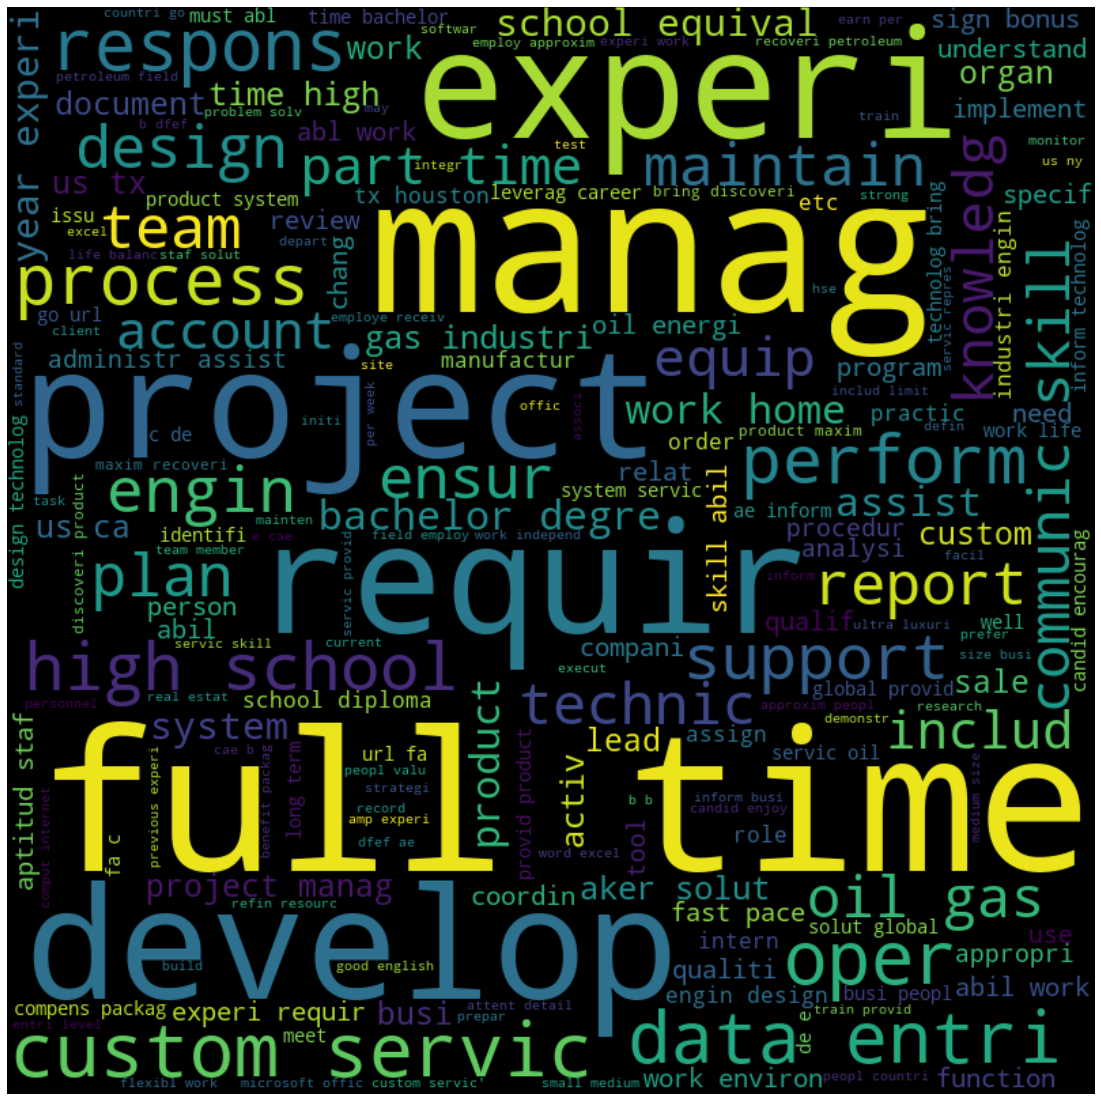

In [38]:
real_job=df[df["fraudulent"]==1]["text"].values
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = STOPWORDS).generate(str(real_job))

fig = plt.figure(figsize = (30,20))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')

In [40]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

<BarContainer object of 10 artists>

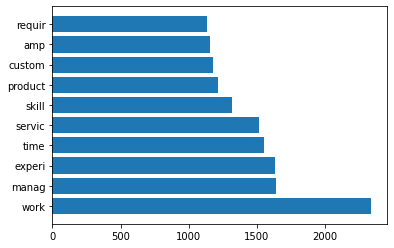

In [41]:
pos_1=defaultdict(int)

for text in df[df["fraudulent"]==1]["text"]:
    for words in generate(text,1):
        pos_1[words]+=1
        
pos=pd.DataFrame(sorted(pos_1.items(),key=lambda x: x[1],reverse=True))
plt.barh(pos[0][:10],pos[1][:10])

In [42]:
vectorizer=TfidfVectorizer(strip_accents='unicode',
                           analyzer='word',
                           ngram_range=(1, 2),
                           max_features=15000,
                           smooth_idf=True,
                           sublinear_tf=True)

vectorizer.fit(df["text"])
X = vectorizer.transform(df["text"])

In [43]:
y=df["fraudulent"]

X_train, X_test, y_train, y_test = train_test_split(X.toarray(), y, test_size=0.20, random_state=42)

In [44]:
model=GaussianNB()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)

In [45]:
print(f"Accuracy score: {accuracy_score(y_test,y_pred)}")

Accuracy score: 0.9765100671140939


In [46]:
print(f"classification_report:\n {classification_report(y_test,y_pred)}")

classification_report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3395
           1       0.89      0.61      0.72       181

    accuracy                           0.98      3576
   macro avg       0.94      0.80      0.86      3576
weighted avg       0.98      0.98      0.97      3576



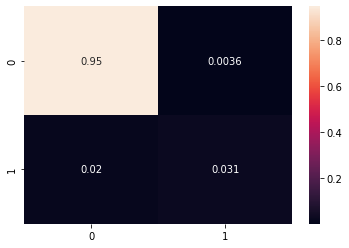

In [47]:
cf_matrix=confusion_matrix(y_test,y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot = True)